<a href="https://colab.research.google.com/github/vojtechremis/RADcv/blob/main/01RAD_Homework4_Remis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Vojtěch Remiš


# 01RAD – Homework Assignment 01 (After Exercise 04)

This homework guides you through data preparation, exploratory analysis, and simple linear regression using a housing market dataset.




## Conditions and grading

- Work on the assignment individually or in Team. If you discuss specific questions with classmates, mention it in the corresponding answer.





## Submission

Submit your work as a Jupyter notebook (`.ipynb`) runnable in Google Colab. Include your name at the top of the notebook. Deadline: **November 2nd  2025**.




## Dataset

Use the CSV file hosted at:

```
https://raw.githubusercontent.com/francji1/01RAD/main/data/sarasota_houses_mod.csv
```

Load the data with `pandas.read_csv`. The table contains 1 057 houses from the Sarasota (FL) area. Columns:

| column | description |
| --- | --- |
| `price` | sale price in USD |
| `living_area` | interior living area in square feet |
| `bathrooms` | number of bathrooms (can be fractional) |
| `bedrooms` | number of bedrooms |
| `fireplaces` | count of fireplaces |
| `lot_size` | lot size in acres |
| `age` | age of the house (years) |
| `fireplace` | boolean indicator whether the house has at least one fireplace |

You will convert the imperial units during the tasks below.




## Data preview



In [16]:
# preview the dataset
import pandas as pd

url = "https://raw.githubusercontent.com/francji1/01RAD/main/data/sarasota_houses_mod.csv"
houses = pd.read_csv(url)
houses.head()


,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age,fireplace
0,142212.0,1982,1.0,3,0,2.00,133,False
1,134865.0,1676,1.5,3,1,0.38,14,True
2,118007.0,1694,2.0,3,1,0.96,15,True
3,138297.0,1800,1.0,2,2,0.48,49,True
4,129470.0,2088,1.0,3,1,1.84,29,True


In [17]:
# TODO: import required libraries and load the dataset into a pandas DataFrame named `houses`
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.set_theme(style='whitegrid')


## Task 01 – Data audit

Check whether the dataset contains missing values. If it does, discuss whether you can safely remove the affected observations. Identify which variables are quantitative and which are qualitative (categorical). If a variable could be treated either way, state your choice and rationale. Compute basic descriptive statistics for each variable.



In [18]:

### Suggested exchange rates and unit conversions

# with an exchange rate of **1 USD = 23 CZK** and express the price in thousands of CZK.

# Convert areas to square metres:
#  - `living_area` (square feet) → multiply by **0.092903**.
#  - `lot_size` (acres) → multiply by **4046.86**.

In [19]:
# TODO: Task 01
# 1. Missing values
for col in houses.columns:
  missing_rows = houses[houses[col].isna()]

  if len(missing_rows) > 0:
    print(f"{col}: {len(missing_rows)}")
    display(missing_rows)

# 2. Decisions
#   price = NaN: remove rows from dataset since price is target variable
#   lot_size = NaN: keep rows in dataset since we are not sure, feature 'lot_size' will be used in model
houses.drop(houses[houses['price'].isna()].index, inplace=True)

# 3. Convert quantities
houses['price_thous_czk'] = houses['price'] * 23 / 1000
houses['living_area_m2'] = houses['living_area'] * 0.092903
houses['lot_size_m2'] = houses['lot_size'] * 4046.86

price: 2


,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age,fireplace
613,NaN,2960,2.5,4,1,0.61,8,True
737,NaN,1675,2.5,2,1,0.04,18,True


lot_size: 9


,price,living_area,bathrooms,bedrooms,fireplaces,lot_size,age,fireplace
6,50709.0,960,1.5,2,0,NaN,12,False
128,101997.0,1214,1.5,2,0,NaN,17,False
251,282373.0,2793,2.5,3,1,NaN,21,True
412,168065.0,1016,2.0,2,0,NaN,41,False
426,247639.0,1016,2.0,2,0,NaN,41,False
477,97476.0,1219,1.5,2,0,NaN,19,False
501,99311.0,1281,2.5,2,1,NaN,18,True
740,247839.0,1536,1.5,3,1,NaN,66,True
1036,197956.0,2314,2.5,4,1,NaN,1,True



## Task 02 – Unit conversion and filtering

Create a cleaned subset of the data that satisfies all of the following:

1. Convert `price` to thousands of CZK using the exchange rate given above.
2. Convert `living_area` and `lot_size` to square metres.
3. Keep only houses that are older than 10 years but not older than 50 years.
4. Keep only houses with price below 7 500 CZK (in thousands), and lot size between 500 m² and 5 000 m².
5. Convert `bathrooms` and `bedrooms` to categorical variables with three levels of your choice (justify the cut points in your report).

Use this filtered dataset for the remaining tasks unless explicitly noted otherwise, and focus on these variables: `price_czk`, `living_area_m2`, `lot_size_m2`, `bedrooms_cat`, `bathrooms_cat`, `age`, `fireplace`.



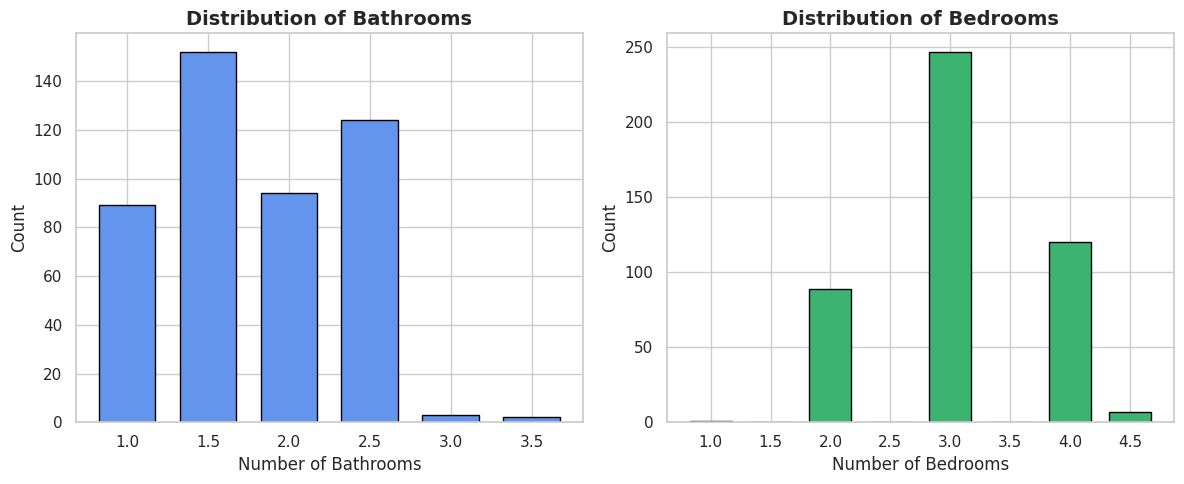

In [20]:
# 1. Keeping only houses in...
mask = (
    (houses['age'] <= 10) |
    (houses['age'] > 50) |
    (houses['price_thous_czk'] >= 7500) |
    (houses['lot_size_m2'] < 500) |
    (houses['lot_size_m2'] > 5000)
)
houses.drop(houses[mask].index, inplace=True)

# 1b. Drop houses with lot_size_m2 = nan (because of condition)
houses.dropna(subset=['lot_size_m2'], inplace=True)


# 2. Checking bathrooms and bedrooms histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
min_bath, max_bath = houses['bathrooms'].min(), houses['bathrooms'].max()
bins_bath = np.arange(np.floor(min_bath), np.ceil(max_bath) + 0.5, 0.5)

plt.hist(houses['bathrooms'], bins=bins_bath, color="cornflowerblue", edgecolor="black",
         rwidth=0.7, align='left')
plt.title("Distribution of Bathrooms", fontsize=14, weight='bold')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
min_bed, max_bed = houses['bedrooms'].min(), houses['bedrooms'].max()
bins_bed = np.arange(np.floor(min_bed), np.ceil(max_bed) + 0.5, 0.5)

plt.hist(houses['bedrooms'], bins=bins_bed, color="mediumseagreen", edgecolor="black",
         rwidth=0.7, align='left')
plt.title("Distribution of Bedrooms", fontsize=14, weight='bold')
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


# 3. Converting bathrooms and bedrooms to categorical variables
houses['bedrooms_cat'] = pd.cut(
    houses['bedrooms'],
    bins=[-0.1, 2, 3, float('inf')],
    labels=['1-2', '3', '>=4'],
    ordered=True,
    right=True,
    include_lowest=True
)

houses['bathrooms_cat'] = pd.cut(
    houses['bathrooms'],
    bins=[-0.1, 1.0, 2.0, float('inf')],
    labels=['1', '1.5-2.0', '>=2.5'],
    ordered=True,
    right=True,
    include_lowest=True
)

# 4. Reducing columns to only necessary ones (to keep dataset clear)
houses_df = houses[['living_area_m2', 'lot_size_m2', 'bedrooms', 'bedrooms_cat', 'bathrooms', 'bathrooms_cat', 'age', 'fireplace', 'fireplaces', 'price_thous_czk']].copy()

#### Converting number of bedrooms and bathrooms to categorical variables - Report

For bedrooms I created 3 categories:
- 1-2 ... smaller houses (up to 2 bedrooms). Houses with only 1 bedroom could also be interesting for price prediction, although only few samples are presented in dataset.
- 3 ... medium size houses (up to 3 bedrooms)
- \>=4 ... larger houses (up to 4 bedrooms)

For bathrooms I created 3 categories:
- 1 ... smaller houses (up to 1 bathroom)
- 1.5-2.0 ... medium size houses (up to 2 bathrooms)
- \>=2.5 ... larger houses (up to 2.5 bathrooms)



## Task 03 – Price comparison (fireplace vs no fireplace)

Compare the mean price of houses with a fireplace to those without one. Test the hypothesis that houses with a fireplace have a higher mean price at the 1% significance level. Clearly state the hypotheses, the test statistic you use, its value, and your conclusion.



In [21]:
# 1. Get prices for 'fireplace = False' and 'fireplace = True'
fireplace_prices = houses.loc[houses['fireplace'] == True, 'price_thous_czk']
no_fireplace_prices = houses.loc[houses['fireplace'] == False, 'price_thous_czk']

# 2. Checking mean for both scenarios
mean_with = fireplace_prices.mean()
mean_without = no_fireplace_prices.mean()

print(f'Mean (with fireplace): {mean_with:,.0f}')
print(f'Mean (no fireplace):   {mean_without:,.0f}\n')

# Welch's two-sample t-test (two-sided)
t_stat, p_two_sided = stats.ttest_ind(
    fireplace_prices, no_fireplace_prices, equal_var=False
)

# One-sided p-value for higher mean with fireplace
if t_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - p_two_sided / 2

alpha = 0.01
reject = p_one_sided < alpha

print(
    'Hypothesis testing (one-sided): \n'
    'H0: μ_fireplace <= μ_no_fireplace  vs.  H1: μ_fireplace > μ_no_fireplace \n\n'
    'Conclusion: \n'
    f't = {t_stat:.3f}, p_one-sided = {p_one_sided:.5f}, reject_H0_at_1pct = {reject}\n'
)

if reject:
    print('At 1% significance level, we reject H0 and conclude that houses with a fireplace have a higher mean price.')
else:
    print('At 1% significance level, we do not reject H0; we do not have sufficient evidence that houses with a fireplace have a higher mean price.')

Mean (with fireplace): 3,757
Mean (no fireplace):   2,797

Hypothesis testing (one-sided): 
H0: μ_fireplace <= μ_no_fireplace  vs.  H1: μ_fireplace > μ_no_fireplace 

Conclusion: 
t = 11.252, p_one-sided = 0.00000, reject_H0_at_1pct = True

At 1% significance level, we reject H0 and conclude that houses with a fireplace have a higher mean price.


### Task #03 conclusion
The average price of houses with a fireplace is 3 757 k CZK, while for houses without a fireplace it is 2 797 k CZK. A two-sample t-test shows that this difference is statistically significant (t = 11.252, p << 0.01). Therefore, we reject the null hypothesis of equal means at the 1% significance level. This indicates that houses with a fireplace are significantly more expensive than those without a fireplace.


# Data visualisation

## Task 04 – Exploratory plots

- Draw scatter plots for each pair of numerical variables, using colour to indicate the presence of a fireplace (`fireplace`).
- Plot boxplots (or violin plots) of `price_czk` against the categorical versions of `bedrooms`, `bathrooms`, and the boolean `fireplace` indicator.
- Display a histogram of `price_czk` and overlay a kernel density estimate.



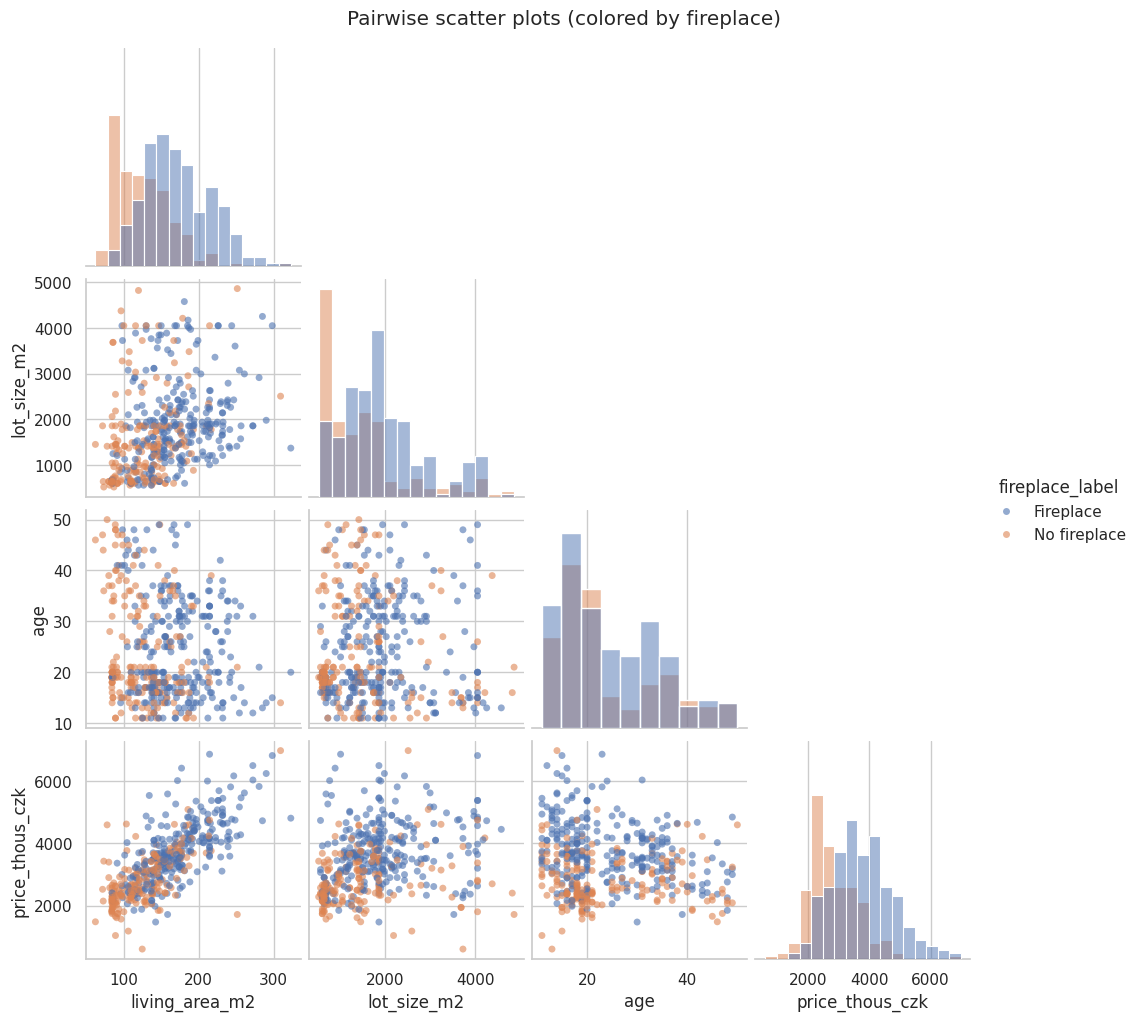

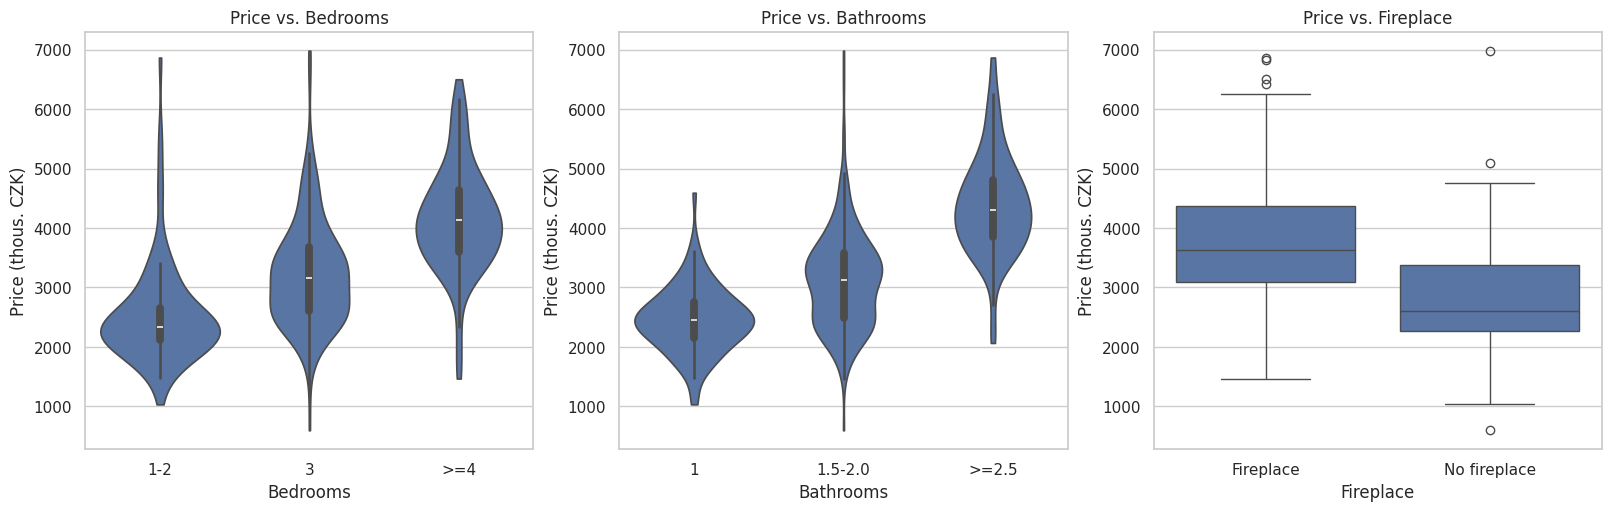

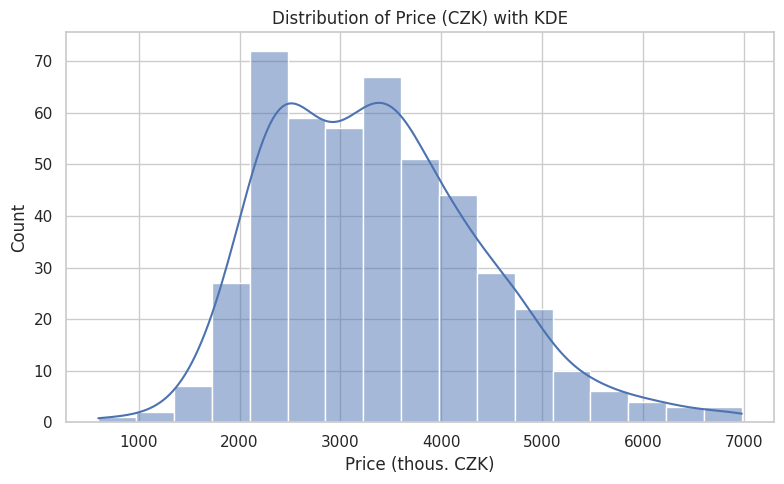

In [22]:
# Copy data frame for exploratory analysis (to prevent changes on the original data)
houses_explor = houses_df.copy()

# Ensure fireplace is binary/boolean and create a nice label for legends
houses_explor['fireplace_label'] = houses_explor['fireplace'].map({False: "No fireplace", True: "Fireplace"})

# 1) Scatter plots for each pair of numerical variables, colored by fireplace
num_cols = ['living_area_m2', 'lot_size_m2', 'age', 'price_thous_czk']

sns.pairplot(
    data=houses_explor[num_cols + ['fireplace_label']],
    hue="fireplace_label",
    diag_kind="hist",
    corner=True,
    plot_kws=dict(alpha=0.6, s=25, edgecolor='none')
)
plt.suptitle("Pairwise scatter plots (colored by fireplace)", y=1.02)
plt.show()

# 2) Boxplots or violin plots of price_czk vs categorical bedrooms/bathrooms/fireplace
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

# Choose either violin or box. Here: violin with inner box for detail.
sns.violinplot(data=houses_explor, x='bedrooms_cat', y='price_thous_czk', ax=axes[0], inner='box', cut=0)
axes[0].set_title("Price vs. Bedrooms")
axes[0].set_xlabel("Bedrooms")
axes[0].set_ylabel("Price (thous. CZK)")
axes[0].tick_params(axis='x', rotation=0)

sns.violinplot(data=houses_explor, x='bathrooms_cat', y='price_thous_czk', ax=axes[1], inner='box', cut=0)
axes[1].set_title("Price vs. Bathrooms")
axes[1].set_xlabel("Bathrooms")
axes[1].set_ylabel("Price (thous. CZK)")

sns.boxplot(data=houses_explor, x='fireplace_label', y='price_thous_czk', ax=axes[2])
axes[2].set_title("Price vs. Fireplace")
axes[2].set_xlabel("Fireplace")
axes[2].set_ylabel("Price (thous. CZK)")

plt.show()

# 3) Histogram of price_czk with KDE overlay
plt.figure(figsize=(8, 5))
sns.histplot(houses_explor['price_thous_czk'], kde=True, bins='auto')
plt.title("Distribution of Price (CZK) with KDE")
plt.xlabel("Price (thous. CZK)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Task 05 – Combined categories

For the combinations of `bedrooms_cat` and `bathrooms_cat`, visualise the distribution of `price_czk`. Ensure that the plot clearly shows which combinations exist in the filtered dataset and whether price levels differ across them.



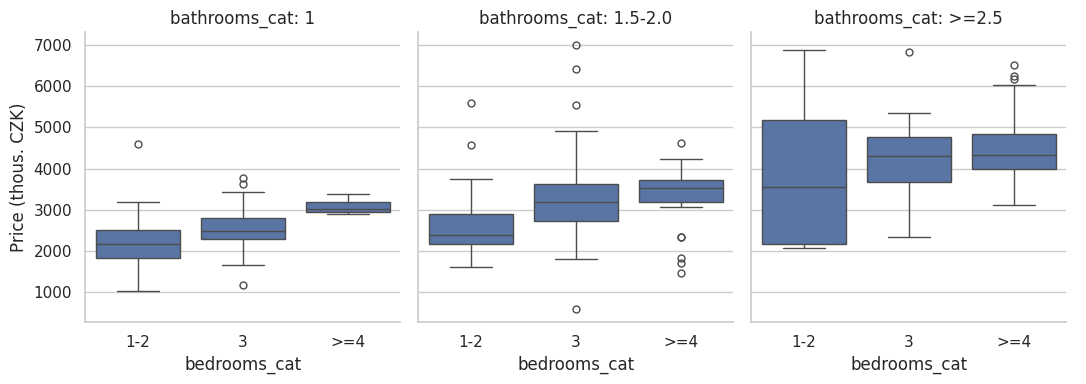

In [23]:
g = sns.catplot(
    data=houses_explor,
    x='bedrooms_cat', y='price_thous_czk',
    col='bathrooms_cat', kind='box',
    order=['1-2', '3', '>=4'], col_order=['1', '1.5-2.0', '>=2.5'],
    height=4, aspect=0.9, sharey=True
)
g.set_titles('bathrooms_cat: {col_name}')
g.set_axis_labels('bedrooms_cat', 'Price (thous. CZK)')
plt.tight_layout()
plt.show()


## Task 06 – Focus on two-bedroom houses

Restrict the data to houses with exactly two bedrooms (before categorisation). Plot `price_czk` against `living_area_m2`, colour the points by `fireplace`, and scale the point size according to the number of bathrooms (treat `bathrooms` as numeric for this plot).




**From this point on, continue working with the subset of two-bedroom houses unless a task specifies otherwise.**



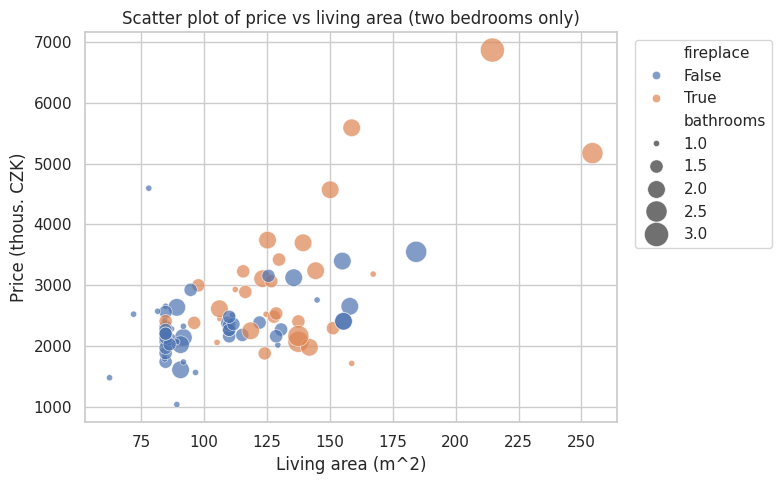

In [24]:
# 1) vycházej z původních (nekategorizovaných) sloupců
houses_df_2br = houses_df.loc[houses_df['bedrooms'] == 2, ['price_thous_czk', 'living_area_m2', 'fireplace', 'bathrooms']]

# 4) vykreslení
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=houses_df_2br,
    x='living_area_m2', y='price_thous_czk',
    hue='fireplace',
    size='bathrooms', sizes=(20, 300),
    alpha=0.7, edgecolor='white', linewidth=0.5
)
ax.set_xlabel('Living area (m^2)')
ax.set_ylabel('Price (thous. CZK)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title('Scatter plot of price vs living area (two bedrooms only)')
plt.tight_layout()
plt.show()


# Simple linear regression




## Task 07 – Simple regression (with and without intercept)

Fit two linear models explaining `price_czk` by `living_area_m2`: one with an intercept and one without. Report $R^2$ and the $F$-statistic for both models. Choose the model you prefer and justify your choice. Using the selected model, answer whether price depends on living area and by how much the expected price changes if the living area increases by 20 m².



In [25]:
# 1) Fit models
m_int = smf.ols('price_thous_czk ~ living_area_m2', data=houses_df_2br).fit() # Intercept
m_no_int = smf.ols('price_thous_czk ~ living_area_m2 - 1', data=houses_df_2br).fit() # No intercept

# 2) Metrics
print(f'With intercept: R^2 = {m_int.rsquared:.4f}, \tF = {m_int.fvalue:.2f}, \tp(F) = {m_int.f_pvalue:.3g}, \tAIC = {m_int.aic:.1f}')
print(f'No intercept: R^2 = {m_no_int.rsquared:.4f}, \tF = {m_no_int.fvalue:.2f}, \tp(F) = {m_no_int.f_pvalue:.3g}, \tAIC = {m_no_int.aic:.1f}')
print('\n\n')

# Print models summary
print('Model with intercept summary:')
display(m_int.summary())

print('\nModel without intercept summary:')
display(m_no_int.summary())

With intercept: R^2 = 0.3837, 	F = 54.17, 	p(F) = 9.69e-11, 	AIC = 1417.5
No intercept: R^2 = 0.9319, 	F = 1203.90, 	p(F) = 4.04e-53, 	AIC = 1421.7



Model with intercept summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_thous_czk   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     54.17
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           9.69e-11
Time:                        04:18:30   Log-Likelihood:                -706.75
No. Observations:                  89   AIC:                             1417.
Df Residuals:                      87   BIC:                             1422.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        668.3580    266.505      2.508      0.014     138.650    1198.066
living_area_m2    16.7083      2.270      7.360      0.000      12.196      21.220
==============================================================================
Omnibus:                       37.727   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.134
Skew:                           1.442   Prob(JB):                     4.03e-23
Kurtosis:                       7.415   Cond. No.                         429.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Model without intercept summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        price_thous_czk   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              1204.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):                    4.04e-53
Time:                        04:18:30   Log-Likelihood:                         -709.85
No. Observations:                  89   AIC:                                      1422.
Df Residuals:                      88   BIC:                                      1424.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
living_area_m2    22.1842      0.639     34.697      0.000      20.914      23.455
==============================================================================
Omnibus:                       20.339   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.987
Skew:                           0.829   Prob(JB):                     1.26e-09
Kurtosis:                       5.882   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# 4) Change of price for +20 m^2
slope = m_int.params['living_area_m2']
delta20 = slope * 20
print(f'Expected price change for +20 m^2: {delta20:,.0f}k CZK (slope = {slope:,.2f}k CZK/m^2)')

Expected price change for +20 m^2: 334k CZK (slope = 16.71k CZK/m^2)


#### Task #07 conclusion: price_thous_czk depends on living_area_m2
I choose the model with an intercept, because in real-estate pricing it is not reasonable to assume that a house with zero living area would have a price of exactly zero. Also, the intercept model has a lower AIC, making it the better fit.

Since p-value is extremely small (<<0.001), we can reject null hypothesis (all regression coefficients are equal to zero). Thus we can say that price_thous_czk depends on living_area_m2.

A 20 m^2 increase in living area is associated with an expected price increase of 334 k CZK, based on the estimated slope of 16.71k CZK per m^2.

## Task 08 – Separate models by fireplace

Fit the same simple regression separately for houses with a fireplace and without a fireplace. Which group exhibits a stronger linear relationship between price and living area? By how much does the slope differ between the two models? Compute 95% confidence intervals for the slopes and discuss whether they overlap. Estimate the percentage difference in expected price for a 160 m² house with a fireplace versus one without a fireplace.

In [27]:
# 0) Prepare datasets
houses_df_2br_fireplace = houses_df_2br[houses_df_2br['fireplace'] == True]
houses_df_2br_nofireplace = houses_df_2br[houses_df_2br['fireplace'] == False]

# 1) Fit models
m_fireplace = smf.ols('price_thous_czk ~ living_area_m2', data=houses_df_2br_fireplace).fit() # With fireplace
m_no_fireplace = smf.ols('price_thous_czk ~ living_area_m2', data=houses_df_2br_nofireplace).fit() # Without fireplace

# 2) Metrics
print(f'With intercept:    R^2 = {m_fireplace.rsquared:.4f},     F = {m_fireplace.fvalue:.2f},     p(F) = {m_fireplace.f_pvalue:.3g},     AIC = {m_fireplace.aic:.1f}')
print(f'No intercept:      R^2 = {m_no_fireplace.rsquared:.4f},   F = {m_no_fireplace.fvalue:.2f},   p(F) = {m_no_fireplace.f_pvalue:.3g},   AIC = {m_no_fireplace.aic:.1f}')

# 3) Stronger linear relationship (by R^2)
stronger = 'With fireplace' if m_fireplace.rsquared >= m_no_fireplace.rsquared else 'Without fireplace'
print(f'Stronger linear relationship (by R^2): {stronger}')

# 4) Slope difference
beta_fire = m_fireplace.params['living_area_m2']
beta_no_fire = m_no_fireplace.params['living_area_m2']

diff = beta_fire - beta_no_fire
print(f'Slope difference: {diff:.2f}\n\n')

# 5) Confidence intervals
m_fireplace_conf_int = m_fireplace.conf_int().loc['living_area_m2']
m_no_fireplace_conf_int = m_no_fireplace.conf_int().loc['living_area_m2']

print('95% CI pro sklon living_area_m2:')
print(f'\tWith fireplace:    [{m_fireplace_conf_int[0]:.3f}, {m_fireplace_conf_int[1]:.3f}]')
print(f'\tWithout fireplace: [{m_no_fireplace_conf_int[0]:.3f}, {m_no_fireplace_conf_int[1]:.3f}]')
print('As shown above, 95% confidence intervals do not overlap, indicating a significant difference in slopes.\n\n')

# 6) Expected price at 160 m^2
inter_fire = m_fireplace.params['Intercept']
inter_no = m_no_fireplace.params['Intercept']

beta_fire = m_fireplace.params['living_area_m2']
beta_no = m_no_fireplace.params['living_area_m2']

p_fire = inter_fire + beta_fire * 160
p_no_fire = inter_no + beta_no * 160

pct_diff = 100 * (p_fire - p_no_fire) / p_no_fire

print(f'Percent difference estimate: {pct_diff:.2f}%')

With intercept:    R^2 = 0.4346,     F = 24.60,     p(F) = 2.23e-05,     AIC = 557.9
No intercept:      R^2 = 0.1621,   F = 10.26,   p(F) = 0.00231,   AIC = 842.9
Stronger linear relationship (by R^2): With fireplace
Slope difference: 12.77


95% CI pro sklon living_area_m2:
	With fireplace:    [12.572, 30.096]
	Without fireplace: [3.199, 13.920]
As shown above, 95% confidence intervals do not overlap, indicating a significant difference in slopes.


Percent difference estimate: 28.30%


### Task #08 conclusion

Separating the regression by fireplace status reveals clear differences between the two groups. Houses with a fireplace show a stronger linear relationship between price and living area, as indicated by a higher R^2 (≈ 0.43 vs. ≈ 0.16).

The estimated slopes also differ substantially: the model for houses with a fireplace has a slope that is about **12.77 k CZK/m^2** higher than the model without a fireplace. The 95% confidence intervals for the slopes are approximately **[12.57, 30.10]** (with fireplace) and **[3.20, 13.92]** (without fireplace). These intervals **slightly overlap** at the upper end of the interval for houses without a fireplace and the lower end of the interval for houses with a fireplace, so based purely on overlap of confidence intervals we cannot claim a perfectly clear separation. Nevertheless, the point estimates and most of the interval mass indicate a noticeably steeper slope when a fireplace is present.

For a 160 m^2 house, the expected price of a home with a fireplace is approximately **28.3% higher** than that of a comparable house without one. Overall, these results show that fireplaces are associated with both higher prices and a stronger sensitivity of price to living area among two-bedroom houses.


## Task 09 – Visual comparison of models

Create a scatter plot of `living_area_m2` versus `price_czk` showing the two fitted regression lines (with and without a fireplace). Add 90% confidence bands for the mean predictions. Use the plot to comment on whether expected prices differ for houses with living area below 120 m². Explain whether this comparison is appropriate.

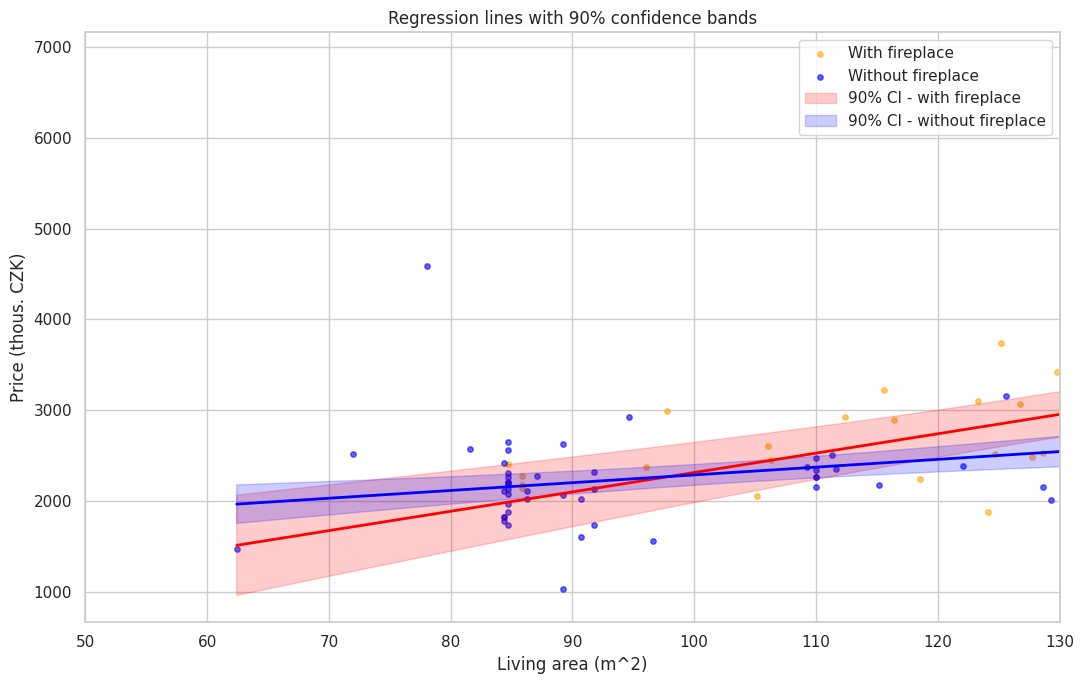

In [28]:
# 1) Create x-grid for whole range of figure
x_min = min(houses_df_2br_fireplace["living_area_m2"].min(),
            houses_df_2br_nofireplace["living_area_m2"].min())
x_max = max(houses_df_2br_fireplace["living_area_m2"].max(),
            houses_df_2br_nofireplace["living_area_m2"].max())

x_grid = np.linspace(x_min, x_max, 200)
X_grid_df = pd.DataFrame({"living_area_m2": x_grid})

# 2) Predictions with 90% CI (and extracting components)
pred_fire = m_fireplace.get_prediction(X_grid_df).summary_frame(alpha=0.10)
pred_no_fire = m_no_fireplace.get_prediction(X_grid_df).summary_frame(alpha=0.10)

mean_fire = pred_fire["mean"] # mean of predictions (fireplace)
ci_fire_low = pred_fire["mean_ci_lower"] # lower bound of CI (fireplace)
ci_fire_high = pred_fire["mean_ci_upper"] # upper bound of CI (fireplace)

mean_no = pred_no_fire["mean"]
ci_no_low = pred_no_fire["mean_ci_lower"]
ci_no_high = pred_no_fire["mean_ci_upper"]


# 3) Create figure
plt.figure(figsize=(11, 7))

# 3a) Scatter plot of (price_thous_czk, living_area_m2)
plt.scatter(
    houses_df_2br_fireplace["living_area_m2"],
    houses_df_2br_fireplace["price_thous_czk"],
    color="orange", alpha=0.6, label="With fireplace", s=15
)

plt.scatter(
    houses_df_2br_nofireplace["living_area_m2"],
    houses_df_2br_nofireplace["price_thous_czk"],
    color="blue", alpha=0.6, label="Without fireplace", s=15
)


# 3b) Regression lines
plt.plot(x_grid, mean_fire, color="red", linewidth=2)
plt.plot(x_grid, mean_no, color="blue", linewidth=2)


# 3c) Confidence bands (90%)
plt.fill_between(
    x_grid, ci_fire_low, ci_fire_high,
    color="red", alpha=0.2, label="90% CI - with fireplace"
)

plt.fill_between(
    x_grid, ci_no_low, ci_no_high,
    color="blue", alpha=0.2, label="90% CI - without fireplace"
)

# 3d) Labels and title
plt.xlabel("Living area (m^2)")
plt.ylabel("Price (thous. CZK)")
plt.title("Regression lines with 90% confidence bands")
plt.xlim(50, 130)
plt.legend()
plt.tight_layout()
plt.show()

### Task #09 conclusion
As can be seen in the plot, within the region where living_area_m2 <= 120, the confidence intervals for houses with and without a fireplace overlap, and therefore we cannot claim that there is a statistically significant difference in the slopes in this area.


## Task 10 – Residual diagnostics

Plot histograms of the residuals from the models in Task 09. Overlay the density of a normal distribution with zero mean and variance equal to the estimated $\hat{\sigma}^2$ of each model. Comment on the findings and suggest further model improvements. Plot corresponding QQ plots and  discuss them.

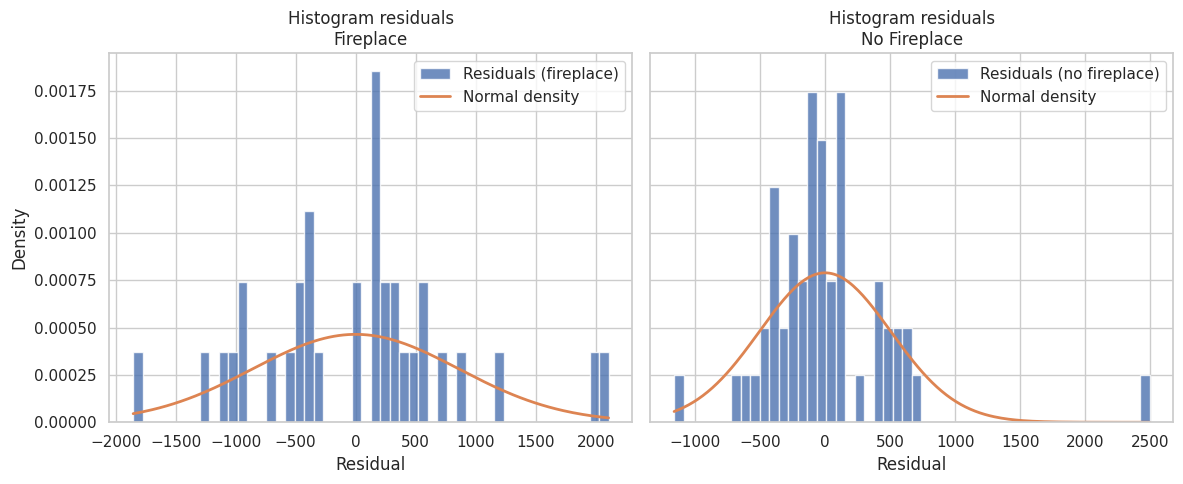

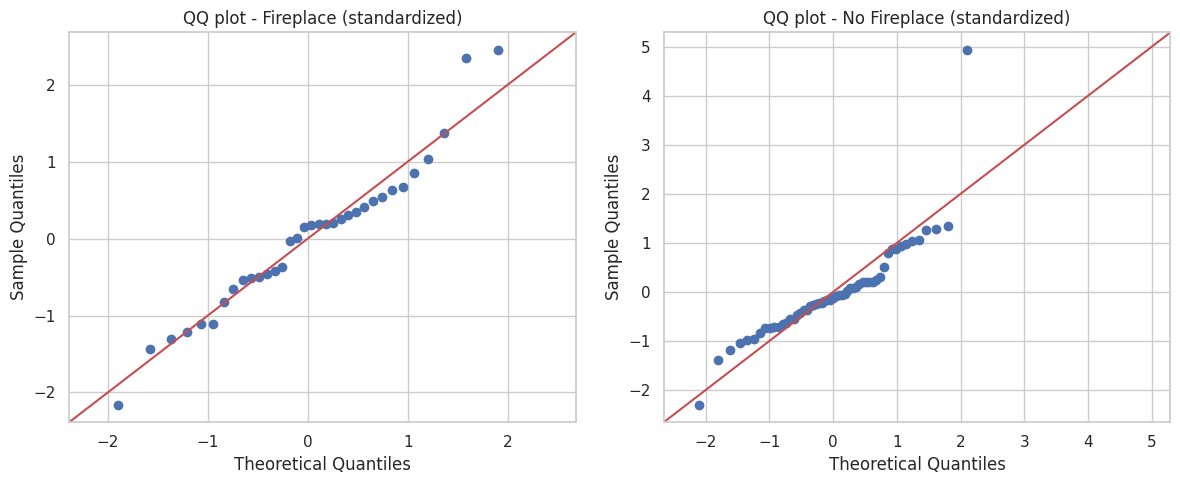

In [29]:
# 1) Extracting residuals and standard deviation
res_m_fireplace = m_fireplace.resid
res_m_no_fireplace = m_no_fireplace.resid

sigma_m_fireplace = np.sqrt(m_fireplace.scale)
sigma_m_no_fireplace = np.sqrt(m_no_fireplace.scale)

# 2) Creating figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# 3) Plotting histogram - with fireplace
ax = axes[0]
ax.hist(res_m_fireplace, bins=50, density=True, alpha=0.8, label="Residuals (fireplace)")

x1 = np.linspace(res_m_fireplace.min(), res_m_fireplace.max(), 200)
ax.plot(x1, stats.norm.pdf(x1, 0, sigma_m_fireplace), linewidth=2, label="Normal density")

ax.set_title("Histogram residuals\nFireplace")
ax.set_xlabel("Residual")
ax.set_ylabel("Density")
ax.legend()

# 4) Plotting histogram - without fireplace
ax = axes[1]
ax.hist(res_m_no_fireplace, bins=50, density=True, alpha=0.8, label="Residuals (no fireplace)")

x2 = np.linspace(res_m_no_fireplace.min(), res_m_no_fireplace.max(), 200)
ax.plot(x2, stats.norm.pdf(x2, 0, sigma_m_no_fireplace), linewidth=2, label="Normal density")

ax.set_title("Histogram residuals\nNo Fireplace")
ax.set_xlabel("Residual")
ax.legend()

plt.tight_layout()
plt.show()

# 5) QQ-Plots (standardized for better visualization)
res_fire_std = res_m_fireplace / sigma_m_fireplace
res_nofire_std = res_m_no_fireplace / sigma_m_no_fireplace

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sm.qqplot(res_fire_std, line="45", ax=axes[0])
axes[0].set_title("QQ plot - Fireplace (standardized)")

sm.qqplot(res_nofire_std, line="45", ax=axes[1])
axes[1].set_title("QQ plot - No Fireplace (standardized)")

plt.subplots_adjust(wspace=25)
plt.tight_layout()
plt.show()

### Task #10 conclusion

The residual diagnostics for both regression models (with and without a fireplace) indicate a partial violation of the classical assumptions regarding normally distributed residuals. Although the central part of the residual distribution aligns reasonably well with a normal distribution, both the histograms and QQ-plots reveal pronounced right-skewness and heavy right tails. The histograms show several very large positive residuals, suggesting that the model systematically underestimates the price of some exceptionally expensive houses.

In the QQ-plots, the lower and central quantiles lie close to the 45° reference line, but the upper quantiles rise sharply above it (especially for the model without a fireplace). This confirms heavy-tailed behaviour and the presence of substantial outliers. The normality assumption is therefore partially violated for both models, especially for homes with very high prices (which is understandable, as expensive houses often reflect individual factors not captured in the dataset-such as the level of interior luxury or unique features).

Model improvements:
The model could be improved by removing extreme price outliers or by applying a transformation (e.g., a logarithmic transform), which would reduce the influence of very expensive properties on the fitted model.